In [1]:
import zipfile
import os

zip_path = 'cnn_dataset (2).zip'
extract_path = 'cnn_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset unzipped successfully.")

Dataset unzipped successfully.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn.functional as F
from scipy import stats
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
import time
import os
import h5py
from torchsummary import summary
from torch.utils import data
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, f1_score
from torch.utils.data import ConcatDataset
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torch.utils.data import random_split
from sklearn.preprocessing import normalize
from torchvision import transforms, datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import torch.nn as nn
import random

In [3]:
dataset_path = 'cnn_dataset/cnn_dataset'
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)


In [4]:
num_classes = len(dataset.classes)
num_train = int(0.7 * len(dataset))
num_val = int(0.15 * len(dataset))
num_test = len(dataset) - num_train - num_val

train_dataset, val_dataset, test_dataset = random_split(dataset, lengths=[num_train, num_val, num_test],
                                                        generator=torch.Generator().manual_seed(7))


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Number of classes in the dataset:", num_classes)
print("Length of dataset",len(dataset))
print("Length of train_size:", len(train_dataset))
print("Length of val_size:", len(val_dataset))
print("Length of test_size:", len(test_dataset))

Number of classes in the dataset: 3
Length of dataset 30000
Length of train_size: 21000
Length of val_size: 4500
Length of test_size: 4500


##VisionTransformer

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VisionTransformer(nn.Module):
    def __init__(self, n_classes):
        super(VisionTransformer, self).__init__()
        self.img_sz = 64  # image size
        self.p_sz = 8     # patch size
        self.dim = 256    # dimension
        self.depth = 10   # depth
        self.heads = 8    # heads
        self.mlp_dim = 512  # MLP dim
        self.ch = 3       # channels

        self.n_patches = (self.img_sz // self.p_sz) ** 2
        p_dim = self.ch * (self.p_sz ** 2)

        self.patch_embed = nn.Linear(p_dim, self.dim)
        self.pos_embed = nn.Parameter(torch.randn(1, self.n_patches + 1, self.dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.dim))
        enc_layer = nn.TransformerEncoderLayer(
            d_model=self.dim,
            nhead=self.heads,
            dim_feedforward=self.mlp_dim,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=self.depth)
        self.class_head = nn.Sequential(
            nn.Linear(self.dim, self.mlp_dim),
            nn.GELU(),
            nn.Linear(self.mlp_dim, n_classes)
        )

    def forward(self, x):
        b, ch, _, _ = x.size()
        x = x.unfold(2, self.p_sz, self.p_sz).unfold(3, self.p_sz, self.p_sz).contiguous().view(b, -1, ch * self.p_sz ** 2)
        x = self.patch_embed(x)
        cls_t = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_t, x), dim=1)

        b, n, _ = x.shape
        pos = self.pos_embed.expand(b, -1, -1)
        x += pos
        x = x.permute(1, 0, 2)  # make sequence the first dimension
        x = self.transformer(x)
        x = self.class_head(x[0])  # take the output corresponding to the class token
        return x
model = VisionTransformer(3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(), lr=0.01)



In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchEmbeddings(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.embed_dim = embed_dim

        self.num_patches = (img_size // patch_size) ** 2
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # Flatten the patches
        x = self.projection(x).flatten(2)
        x = x.transpose(1, 2)  # B, N, E
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_dim):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.mha = nn.MultiheadAttention(embed_dim, num_heads)

        self.layer_norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, embed_dim)
        )

    def forward(self, x):
        # Multi-head attention part
        x = self.layer_norm1(x)
        x2 = x
        x, _ = self.mha(x, x, x)

        # MLP part
        x2 = x
        x = self.layer_norm2(x)
        x = x2 + self.mlp(x)
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, num_classes, embed_dim, num_heads, mlp_dim, num_layers):
        super().__init__()
        self.patch_embeddings = PatchEmbeddings(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.position_embeddings = nn.Parameter(torch.zeros(1, 1 + self.patch_embeddings.num_patches, embed_dim))
        self.encoders = nn.ModuleList([TransformerEncoder(embed_dim, num_heads, mlp_dim) for _ in range(num_layers)])
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.patch_embeddings(x)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x += self.position_embeddings
        for encoder in self.encoders:
            x = encoder(x)
        x = self.layer_norm(x)
        x = x[:, 0]  # Only use the cls token
        x = self.head(x)
        return x
model = VisionTransformer(
    img_size=64,
    patch_size=16,
    in_channels=3,
    num_classes=3,
    embed_dim=256,
    num_heads=8,
    mlp_dim=512,
    num_layers=6
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [24]:
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5):
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        total = 0
        correct = 0
        for inputs, labels in train_loader:
            # inputs, labels = next(iter(train_loader))
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total +=  labels.size(0)
            correct +=  (predicted == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100*correct / total)
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total +=  labels.size(0)
                correct +=  (predicted == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100*correct / total)
        print('Epoch:', epoch+1, ' Train Accuracy: {:.2f}%'.format(train_accuracies[-1]),
              ' Train Loss:', train_losses[-1],' Validation Accuracy: {:.2f}%'.format(val_accuracies[-1]), ' Validation Loss:', val_losses[-1])

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


Epoch: 1  Train Accuracy: 33.40%  Train Loss: 1.1571768645457583  Validation Accuracy: 33.91%  Validation Loss: 1.1063596967240454
Epoch: 2  Train Accuracy: 33.15%  Train Loss: 1.1008660854901948  Validation Accuracy: 33.29%  Validation Loss: 1.0987482003762687
Epoch: 3  Train Accuracy: 33.56%  Train Loss: 1.0990636225529355  Validation Accuracy: 32.80%  Validation Loss: 1.100259628094418
Epoch: 4  Train Accuracy: 33.12%  Train Loss: 1.0995387375173598  Validation Accuracy: 33.29%  Validation Loss: 1.0986872055161168
Epoch: 5  Train Accuracy: 33.31%  Train Loss: 1.0996257392831124  Validation Accuracy: 33.29%  Validation Loss: 1.0987288733603249


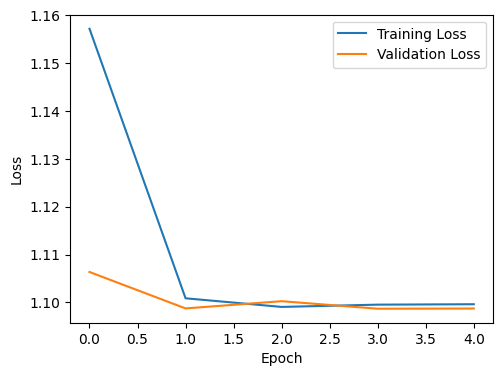

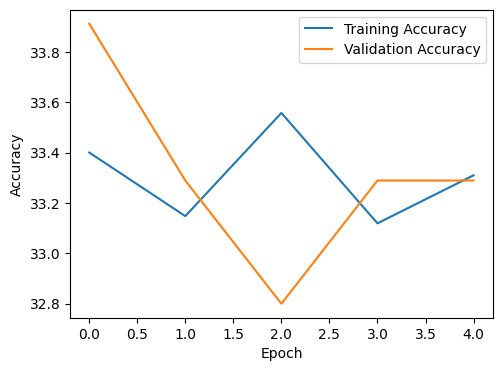

In [25]:
train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5)

In [26]:
#Test Accuracy and Loss
def test_accuracy(model, test_loader):
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Test Accuracy:', correct*100 // total,"%")
    print('Test Loss:', test_loss/len(test_loader))



In [27]:
test_accuracy(model, test_loader)

Test Accuracy: 33 %
Test Loss: 1.0987881153402195


In [28]:
#Confusion Matrix
y_true = []
y_pred = []
def confusion_plot(model, test_loader):
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



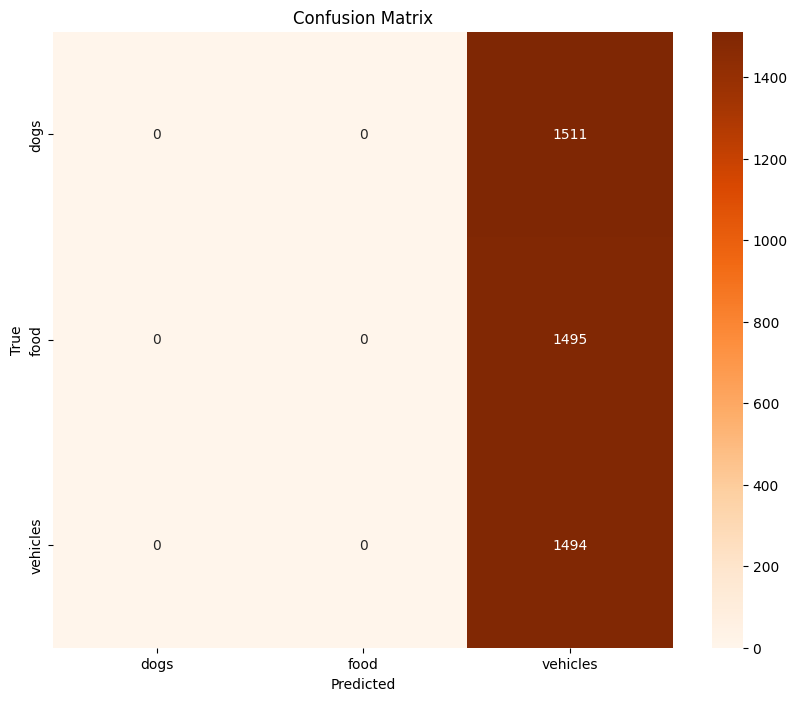

In [29]:
confusion_plot(model, test_loader)

In [30]:
#Evaluation Metrics
def metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1 Score: {:.2f}".format(f1))

metrics(y_true, y_pred)

Precision: 0.11
Recall: 0.33
F1 Score: 0.17


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##EfficientNet

In [ ]:
model = models.efficientnet_b0(pretrained=True)

num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 115MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Epoch: 1  Train Accuracy: 91.70%  Train Loss: 0.2267215027046421  Validation Accuracy: 96.31%  Validation Loss: 0.10821326011398309
Epoch: 2  Train Accuracy: 96.34%  Train Loss: 0.10447137342273374  Validation Accuracy: 96.84%  Validation Loss: 0.09403296376407987
Epoch: 3  Train Accuracy: 97.92%  Train Loss: 0.060690829044173965  Validation Accuracy: 97.11%  Validation Loss: 0.09515327395228537
Epoch: 4  Train Accuracy: 98.09%  Train Loss: 0.052853190881486045  Validation Accuracy: 97.20%  Validation Loss: 0.0912543802233544
Epoch: 5  Train Accuracy: 98.90%  Train Loss: 0.032344750977828275  Validation Accuracy: 97.40%  Validation Loss: 0.09379111688492268


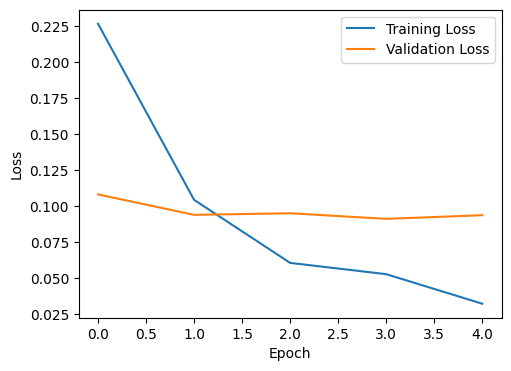

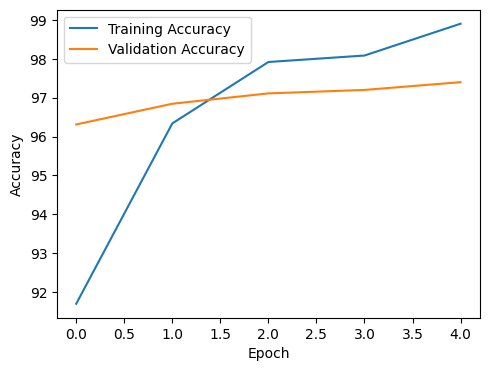

In [ ]:
train_and_validate(model, train_loader, val_loader, optimizer, criterion, epochs=5)

In [ ]:
test_accuracy(model, test_loader)

Test Accuracy: 97 %
Test Loss: 0.08573867998388841


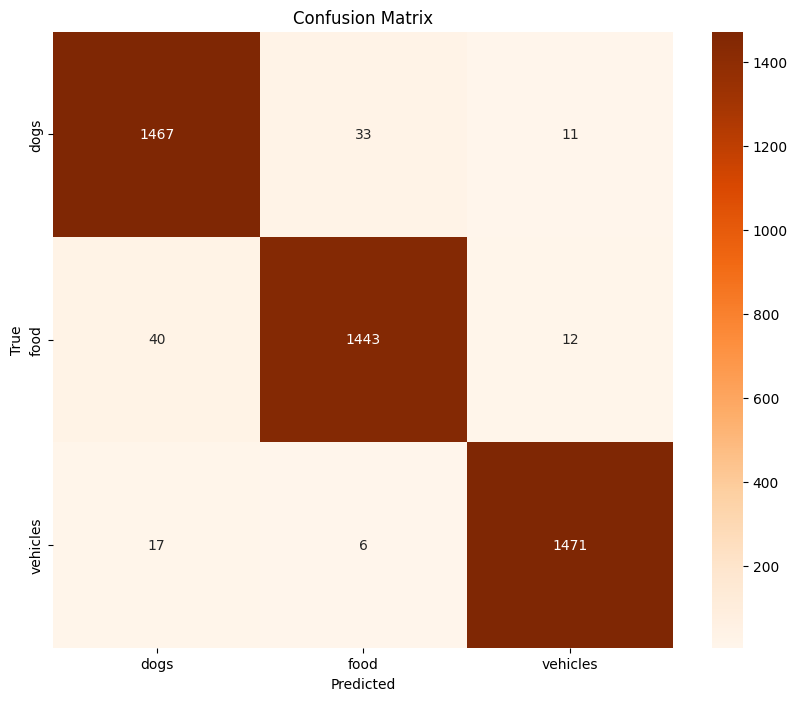

In [ ]:
y_true = []
y_pred = []
confusion_plot(model, test_loader)

In [ ]:
#Evaluation Metrics
def metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print("Precision: {:.2f}".format(precision))
    print("Recall: {:.2f}".format(recall))
    print("F1 Score: {:.2f}".format(f1))

metrics(y_true, y_pred)

Precision: 0.97
Recall: 0.97
F1 Score: 0.97
